In [1]:
import pandas as pd
import re
from soynlp.normalizer import *
from konlpy.tag import Mecab
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

In [2]:
train = pd.read_csv('./data/train.csv')
train.tail()

,idx,class,conversation
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...
3949,3949,직장 내 괴롭힘 대화,희정씨\n네?\n주말에 시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일...


In [3]:
# soynlp 이용하여 ㅋㅋㅋ, ㅠㅠ 등을 처리하고 반복 제거함(default 2)
# 알파벳과 한글 제외한 문법기호, 특수문자, 숫자 등 제거
def preprocess_sentence(sentence):
    emoticon_normalize(sentence)
    repeat_normalize(sentence)
    sentence = re.sub(r'([^ㄱ-ㅎ가-힣])', " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

In [4]:
train_list = []
for sentence in train['conversation']:
    train_list.append(preprocess_sentence(sentence))

In [5]:
train_list[0]

'지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 진짜 죽여버리고 싶게 정말 잘못했습니다 너가 선택해 너가 죽을래 네 가족을 죽여줄까 죄송합니다 정말 잘못했습니다 너에게는 선택권이 없어 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 선택 못하겠습니다 한번만 도와주세요 그냥 다 죽여버려야겠군 이의 없지 제발 도와주세요'

한글을 제외한 영어, 숫자, 문법기호, 특수문자를 모두 제거한 방법과 영어, 숫자, 한글, 문법기호를 모두 포함시킨 방법을 모두 사용해보았는데 미미한 차이지만 전자의 경우가 더 성능이 좋았다. 문법기호의 역할이 크지 않고, 최대 길이를 제한해야 하는 상황에서 유의미한 단어를 더 많이 사용할 수 있기 때문인 것 같다.

### 데이터 길이 분포

max len:  839
mean len:  212.55696202531647


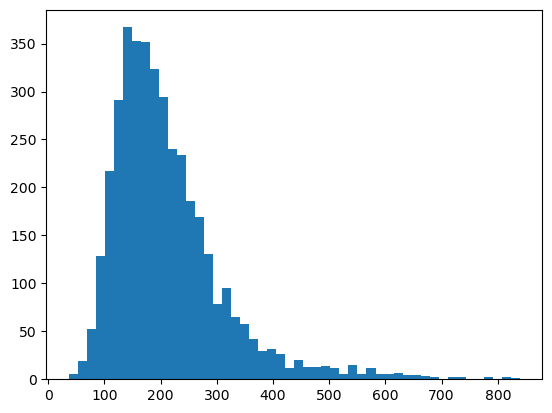

In [6]:
print('max len: ', max(len(review) for review in train_list)) # 데이터셋 내 최대 문장 길이
print('mean len: ', sum(map(len, train_list))/len(train_list)) # 데이터셋 문장 길이 평균
plt.hist([len(review) for review in train_list], bins=50)
plt.show() # 문장 길이 분포 확인

최대 길이는 839, 평균 길이는 212.56이었다. 

### 토큰 개수 분포

In [7]:
mecab = Mecab()
corpus = []
for cor in train_list:
    cor = mecab.morphs(cor)
    corpus.append(cor)

In [8]:
print(corpus[0])

['지금', '너', '스스로', '를', '죽여', '달', '라고', '애원', '하', '는', '것', '인가', '아닙니다', '죄송', '합니다', '죽', '을', '거', '면', '혼자', '죽', '지', '우리', '까지', '사건', '에', '휘말리', '게', '해', '진짜', '죽여', '버리', '고', '싶', '게', '정말', '잘못', '했', '습니다', '너', '가', '선택', '해', '너', '가', '죽', '을래', '네', '가족', '을', '죽여', '줄까', '죄송', '합니다', '정말', '잘못', '했', '습니다', '너', '에게', '는', '선택', '권', '이', '없', '어', '선택', '못', '한다면', '너', '와', '네', '가족', '까지', '모조리', '죽여', '버릴', '거', '야', '선택', '못', '하', '겠', '습니다', '한', '번', '만', '도와', '주', '세요', '그냥', '다', '죽여', '버려야', '겠', '군', '이', '의', '없', '지', '제발', '도와', '주', '세요']


max len:  413
mean len:  104.52759493670887


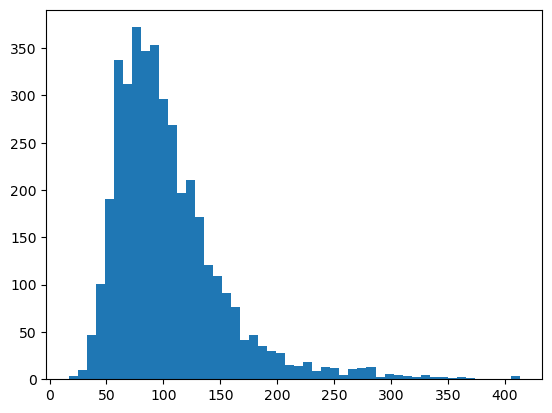

In [9]:
print('max len: ', max(len(cor) for cor in corpus)) # 데이터셋 내 최대 토큰 개수
print('mean len: ', sum(map(len, corpus))/len(corpus)) # 데이터셋 토큰 개수 평균
plt.hist([len(cor) for cor in corpus], bins=50)
plt.show() # 토큰 개수 분포 확인

mecab 기준 토큰의 개수 분포는 최대 토큰 개수 413, 평균 토큰 개수 104.53이었다. 실제 훈련에는 다른 토크나이저를 사용했지만 데이터의 정보량 분포를 대략적으로 확인할 수 있을 것 같다.

### 명사 통계

<Axes: >

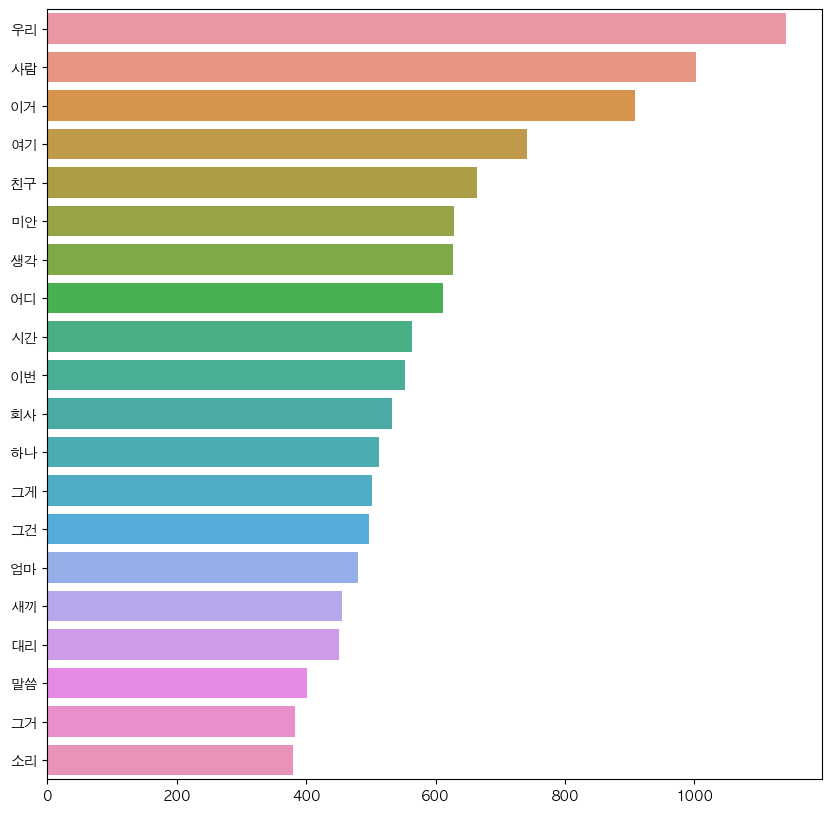

In [10]:
n_corpus = []
for t in train_list:
    for n in mecab.nouns(t):
        if len(n)>1:
            n_corpus.append(n)

count = collections.Counter(n_corpus)
most = count.most_common() #빈도 수 순으로 추출

x, y= [], []
for word,count in most[:20]:
    x.append(word)
    y.append(count)

plt.rcParams['font.family'] = 'AppleGothic'
plt.figure(figsize=(10,10))
sns.barplot(x=y,y=x)

전체 명사 통계의 경우 의존명사 등이 압도적으로 많았기 때문에 두 글자 이상의 명사만 출력하였다. '우리' 가 가장 많았고 '이거', '여기' 같은 지시대명사도 많이 포함되어 있었다.

### 형태소 통게

[Text(0.5, 0, '빈도 수'), Text(0, 0.5, '형태소')]

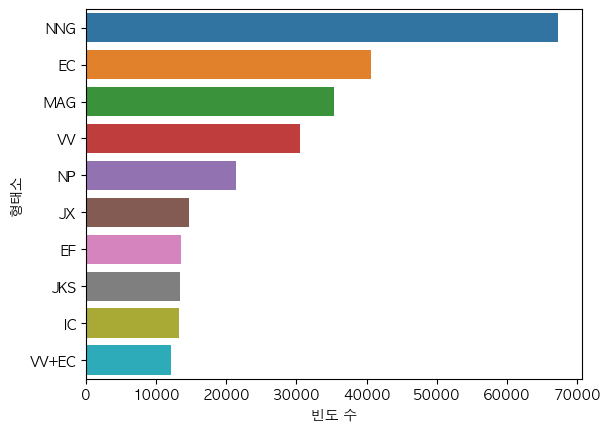

In [11]:
tags = []
for t in train_list:
    temp = mecab.pos(t)
    for p in temp:
        tags.append(p[1])

counter=collections.Counter(tags)


x,y=list(map(list,zip(*counter.most_common(10))))
ax = sns.barplot(x=y,y=x)
ax.set(xlabel = '빈도 수', ylabel = '형태소')

mecab 기준 품사 같은 경우에는 일반 명사가 압도적으로 많았고, 그 다음이 연결 어미, 일반 부사, 동사 순이었다.

### n-gram 통계

In [12]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

In [13]:
m_corpus = []
for t in train_list:
    m_corpus.append(' '.join(mecab.morphs(t)))

[Text(0.5, 0, '빈도 수'), Text(0, 0.5, '2gram 어절')]

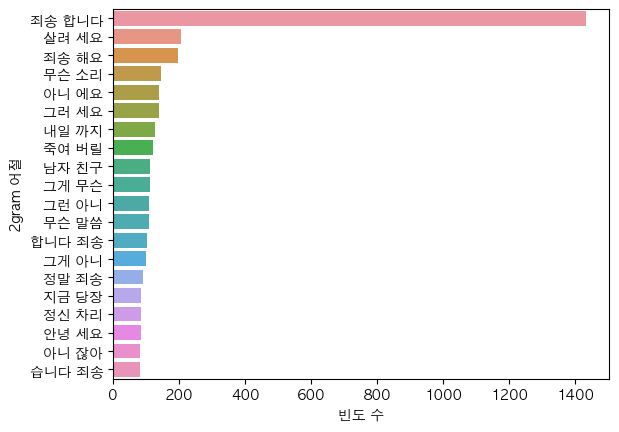

In [14]:
top_n_bigrams=get_top_ngram(m_corpus,2)[:20] 
x,y=map(list,zip(*top_n_bigrams)) 
ax = sns.barplot(x=y,y=x)
ax.set(xlabel = '빈도 수', ylabel = '2gram 어절')

[Text(0.5, 0, '빈도 수'), Text(0, 0.5, '3gram 형태소')]

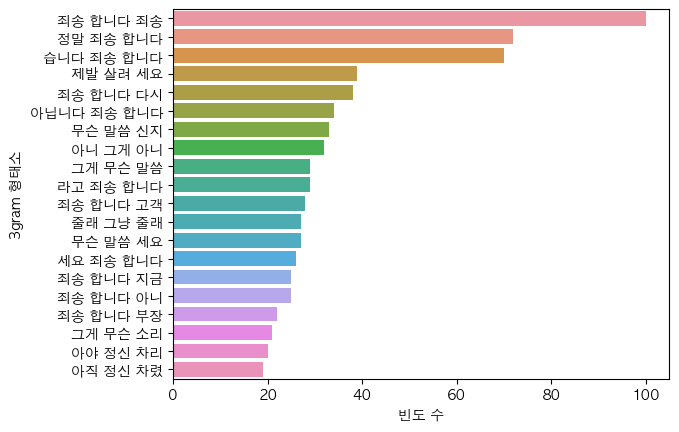

In [15]:
top_n_bigrams=get_top_ngram(m_corpus,3)[:20] 
x,y=map(list,zip(*top_n_bigrams)) 
ax = sns.barplot(x=y,y=x)
ax.set(xlabel = '빈도 수', ylabel = '3gram 형태소')

### 워드 클라우드

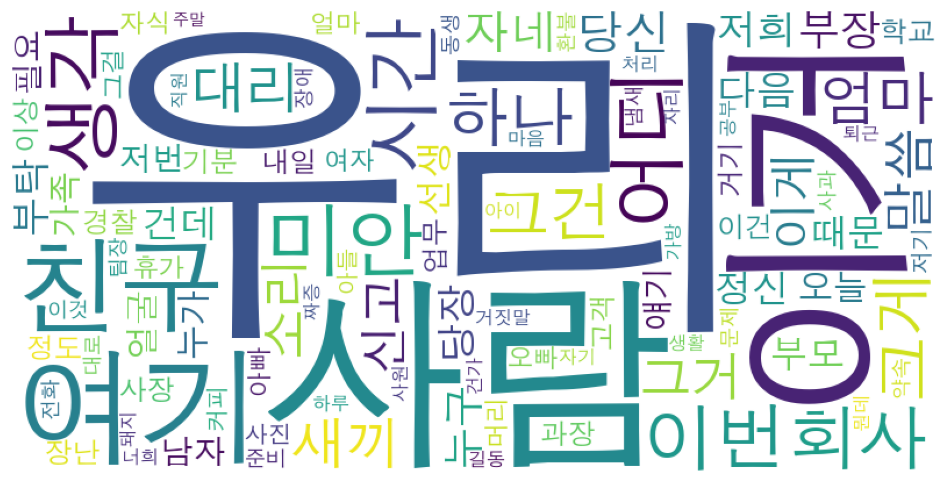

In [18]:
n_corpus2 = list(filter(lambda a: len(a) >= 2, n_corpus))
count = collections.Counter(n_corpus2)

def show_wordcloud(data):
    w = WordCloud(font_path = 'AppleGothic', #글자가 깨져서 폰트 파일의 주소를 할당해 주었다.
        background_color='white',
        max_words=100,
        max_font_size=150,
        scale=2,
        random_state=1)
   
    wordcloud=w.generate_from_frequencies(data)

    fig = plt.figure(1, figsize=(12, 12))
    plt.rcParams['font.family'] = 'AppleGothic'
    plt.axis('off')

    
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(count)